# Hands-On Pertemuan 9: Spark SQL

## Tujuan:
- Mengasah keterampilan analisis data menggunakan Spark SQL.
- Melakukan lebih banyak latihan SQL yang mengarah ke skenario dunia nyata.
- Mempersiapkan mahasiswa untuk menggunakan Spark SQL dalam proyek besar.


In [ ]:
pip install pyspark

### 1. Refresher: Basic SQL Operations in Spark SQL
- **Tugas 1**: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.


In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('MySparkApp').getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



### 2. Advanced Queries for Data Analysis
Gunakan queries lebih kompleks, melibatkan grouping, filtering, dan subqueries.
- **Tugas 2**: Buat SQL query yang menghitung total gaji berdasarkan jenis kelamin dan usia.


In [19]:
# counting all salary above genders and age
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()


+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



- **Tugas Tambahan 2**:
1. Cari rata-rata gaji per departemen.
2. Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.
3. Buat ranking karyawan berdasarkan gaji dalam departemen mereka.


In [20]:
# Avg salary per departement
spark.sql('''
SELECT DeptId, AVG(Salary) as AvgSalary
FROM employees
GROUP BY DeptId
''').show()

# Employees who have above-avg salaries for their respective genders
spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
) AS avg_salary ON e.Gender = avg_salary.Gender
WHERE e.Salary > avg_salary.AvgSalary
''').show()

# Ranking employees above salary in their departements
spark.sql('''
SELECT *, RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS Rank
FROM employees
''').show()


+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+

+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|Rank|
+-----+---+------+------+------+----+
|James| 34|     M|  3000|     1|   1|
|  Lee| 23|     M|  2700|     1|   2|
| Anna| 28|     F|  4100|     2|   1|
+-----+---+------+------+------+----+



### 3. Penggunaan Window Functions dan Subqueries
Latihan penggunaan window functions untuk menemukan karyawan dengan gaji tertinggi dan urutannya berdasarkan kelompok usia.
- **Tugas 3**: Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu.


In [21]:
spark.sql('''
SELECT Name, Age, Salary
FROM (
    SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank_within_age_group
    FROM employees
) ranked_employees
WHERE rank_within_age_group <= 3;
''').show()


+-----+---+------+
| Name|Age|Salary|
+-----+---+------+
|  Lee| 23|  2700|
| Anna| 28|  4100|
|James| 34|  3000|
+-----+---+------+



### 4. Advanced Spark SQL Queries
Menjelajahi queries yang lebih kompleks yang melibatkan multiple joins, subqueries, dan window functions.
- **Tugas 4**: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.


In [22]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

# Avg Salary
spark.sql('''
SELECT DeptName, AVG(Salary) as AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY DeptName
''').show()

# Tren Salary baseid on Age in every departements
spark.sql('''
SELECT DeptName, Age, AVG(Salary) as AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY DeptName, Age
ORDER BY DeptName, Age
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+

+---------+---------+
| DeptName|AvgSalary|
+---------+---------+
|       HR|   2850.0|
|Marketing|   4100.0|
+---------+---------+

+---------+---+---------+
| DeptName|Age|AvgSalary|
+---------+---+---------+
|       HR| 23|   2700.0|
|       HR| 34|   3000.0|
|Marketing| 28|   4100.0|
+---------+---+---------+



Latihan mandiri untuk memperkuat pemahaman tentang Spark SQL dalam analisis data terdistribusi.
- **Tugas 5**: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
- **Tugas 6**: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.


In [ ]:
# Avg salary per departement and ranking employeers above salary
spark.sql("""
SELECT
    e.Name,
    e.DeptId,
    e.Salary,
    AVG(e.Salary) OVER (PARTITION BY e.DeptId) AS AvgSalaryDept,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS RankInDept
FROM
    employees e
ORDER BY
    e.DeptId, RankInDept
""").show()

+-----+------+------+------------------+----------+
| Name|DeptId|Salary|     AvgSalaryDept|RankInDept|
+-----+------+------+------------------+----------+
|  Bob|     1|  3200|2966.6666666666665|         1|
|James|     1|  3000|2966.6666666666665|         2|
|  Lee|     1|  2700|2966.6666666666665|         3|
| Anna|     2|  4100|            3950.0|         1|
|Alice|     2|  3800|            3950.0|         2|
+-----+------+------+------------------+----------+



In [ ]:
# Tren Salary berdasarkan Age di setiap departemen
spark.sql("""
SELECT
    DeptId,
    Age,
    AVG(Salary) OVER (PARTITION BY DeptId ORDER BY Age) as AvgSalaryByAgeInDept
FROM
    employees;
""").show()

+------+---+--------------------+
|DeptId|Age|AvgSalaryByAgeInDept|
+------+---+--------------------+
|     1| 23|              2700.0|
|     1| 34|              2850.0|
|     2| 28|              4100.0|
+------+---+--------------------+



### 5. Advanced Data Analysis and Visualization
Penerapan teknik analisis data yang lebih canggih dan visualisasi menggunakan PySpark dan matplotlib.
- **Tugas 7**: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.


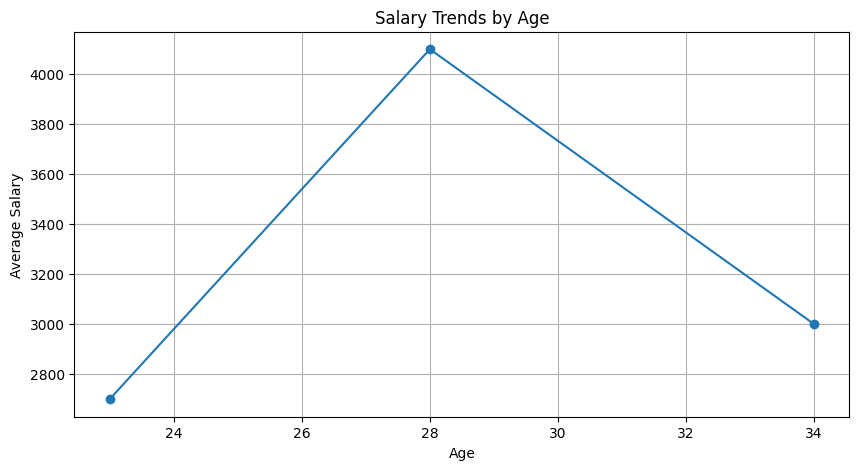

In [17]:
import matplotlib.pyplot as plt

# Analyze salary trends using Spark SQL
salary_trends = spark.sql('''
    SELECT Age, AVG(Salary) AS AverageSalary
    FROM employees
    GROUP BY Age
    ORDER BY Age
''').toPandas()

# Visualize the results with Matplotlib
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

### 6. Homework
- **Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
- **Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
- **Tugas 3**: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti `SUM()`, `AVG()`, `COUNT()`, serta `JOIN` antar tabel serta buat visualisasi yang menarik.


In [14]:
import matplotlib.pyplot as plt

# Calculate the average salary per age group using Spark SQL and create a temporary view
avg_salary_by_age = spark.sql('''
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Age
''')
avg_salary_by_age.createOrReplaceTempView("avg_salary_by_age")

# Find employees with above-average salaries using the temporary view
above_avg_employees = spark.sql('''
    SELECT e.Name, e.Age, e.Salary
    FROM employees e
    JOIN avg_salary_by_age a ON e.Age = a.Age
    WHERE e.Salary > a.AvgSalary
''').toPandas()

# Verify if we have any above-average employees to plot
if not above_avg_employees.empty:
    # Group by age and count the number of employees
    age_group_counts = above_avg_employees.groupby('Age').size().reset_index(name='Count')

    # Create the pie chart and save it as an image
    plt.figure(figsize=(8, 8))
    plt.pie(age_group_counts['Count'], labels=age_group_counts['Age'], autopct='%1.1f%%', startangle=90)
    plt.title('Employees with Above-Average Salaries by Age Group')
    plt.savefig('/home/mibyu/Kuliah/Pyspark/above_avg_salaries_pie_chart.png')
    print("Pie chart saved as 'above_avg_salaries_pie_chart.png'")
else:
    print("No employees found with above-average salaries.")


No employees found with above-average salaries.


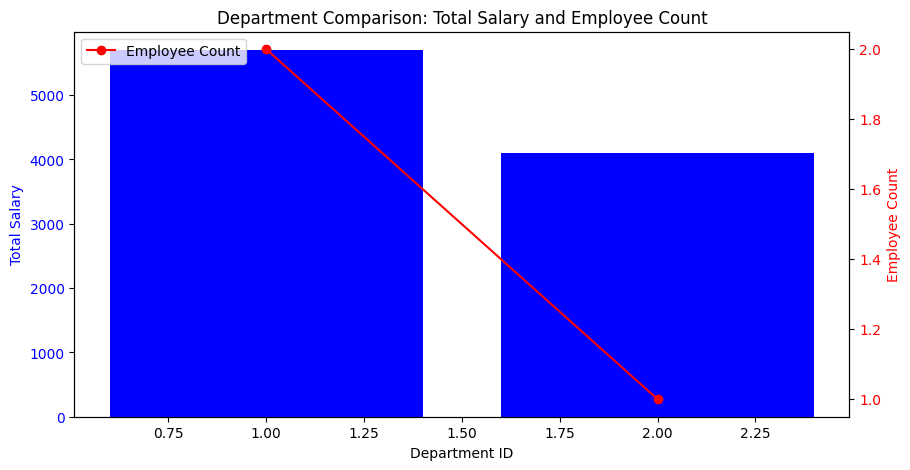

In [16]:
# Calculate department statistics using Spark SQL
department_stats = spark.sql('''
    SELECT DeptId, SUM(Salary) AS TotalSalary, COUNT(*) AS EmployeeCount
    FROM employees
    GROUP BY DeptId
''').toPandas()

# Visualize the comparison with Matplotlib
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(department_stats['DeptId'], department_stats['TotalSalary'], color='b', label='Total Salary')
ax1.set_xlabel('Department ID')
ax1.set_ylabel('Total Salary', color='b')
ax1.tick_params('y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(department_stats['DeptId'], department_stats['EmployeeCount'], color='r', marker='o', label='Employee Count')
ax2.set_ylabel('Employee Count', color='r')
ax2.tick_params('y', labelcolor='r')

plt.title('Department Comparison: Total Salary and Employee Count')
plt.legend(loc='upper left')
plt.show()

In [ ]:
import random
from pyspark.sql import Row

# Data Jurusan Mancing
data_memancing = []
for i in range(150):  # 150 data
    data_memancing.append(Row(
        Nama='Pemancing' + str(i),
        Usia=random.randint(18, 65),
        JenisKelamin=random.choice(['Laki-laki', 'Perempuan']),
        Spesialisasi=random.choice(['Air Tawar', 'Air Laut', 'Fly Fishing']),
        Pengalaman=random.randint(1, 20),  # experiance in year
        LokasiFavorit=random.choice(['Sungai', 'Danau', 'Laut', 'Kolam']),
        IkanFavorit=random.choice(['Ikan Mas', 'Lele', 'Nila', 'Tuna', 'Kakap']),
        JumlahTangkapan=random.randint(0, 50),  # Jumlah tangkapan dalam setahun
        BiayaPeralatan=random.randint(500000, 5000000),  # Cost equipment
        KeanggotaanKlub=random.choice(['Ya', 'Tidak'])
    ))

# DataFrame
df_memancing = spark.createDataFrame(data_memancing)
df_memancing.show(5)  # visualization 5 data first

+----------+----+------------+------------+----------+-------------+-----------+---------------+--------------+---------------+
|      Nama|Usia|JenisKelamin|Spesialisasi|Pengalaman|LokasiFavorit|IkanFavorit|JumlahTangkapan|BiayaPeralatan|KeanggotaanKlub|
+----------+----+------------+------------+----------+-------------+-----------+---------------+--------------+---------------+
|Pemancing0|  18|   Laki-laki|    Air Laut|        18|        Kolam|      Kakap|             28|       1437601|             Ya|
|Pemancing1|  40|   Laki-laki|   Air Tawar|         9|        Kolam|   Ikan Mas|             14|       1049007|          Tidak|
|Pemancing2|  41|   Perempuan| Fly Fishing|        10|        Danau|       Lele|             19|       2571818|          Tidak|
|Pemancing3|  62|   Laki-laki|   Air Tawar|        16|         Laut|       Lele|             48|       2390074|          Tidak|
|Pemancing4|  50|   Perempuan|   Air Tawar|        14|        Danau|       Tuna|             28|       1

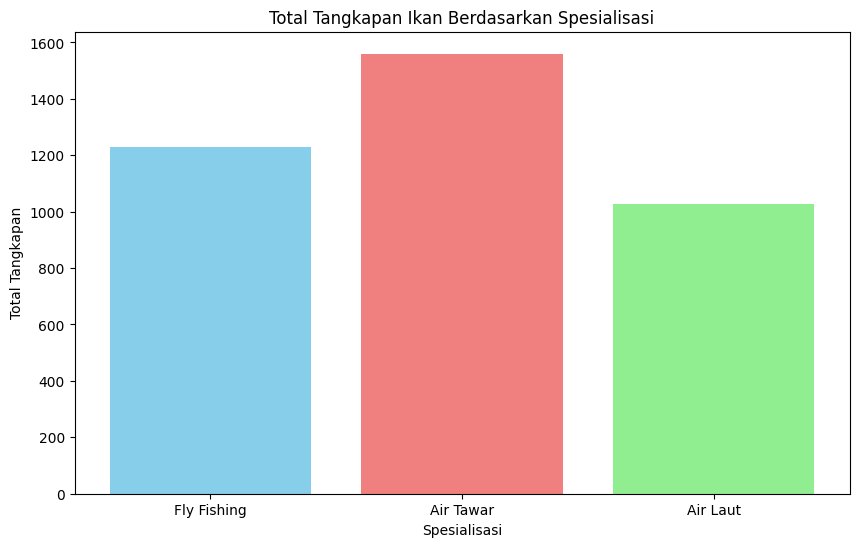

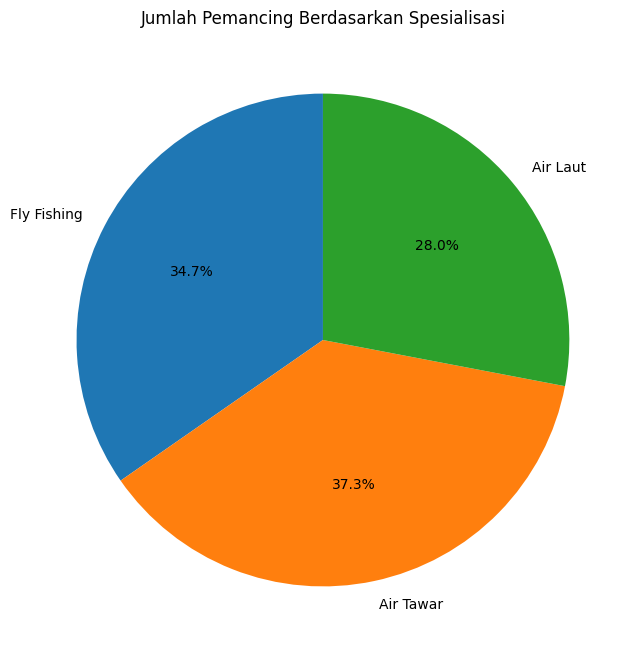

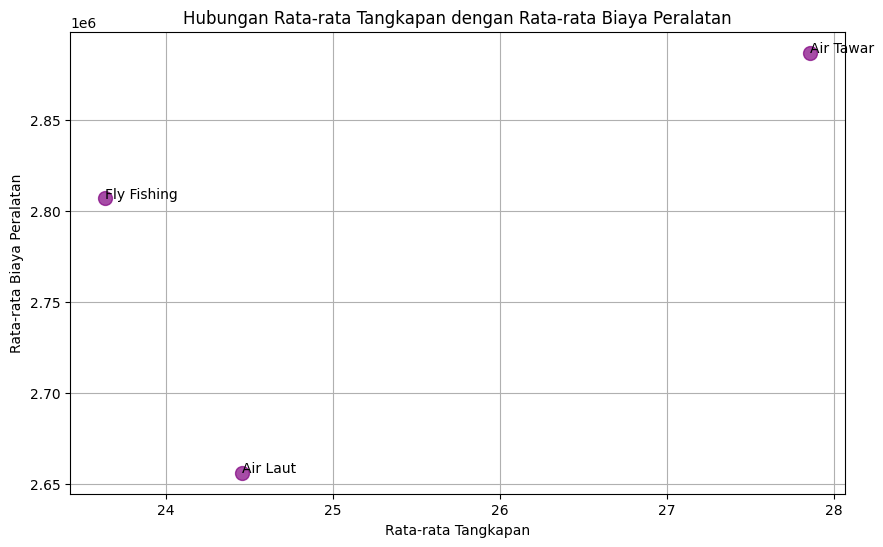

In [ ]:
# Create temporary view for SQL queries
df_memancing.createOrReplaceTempView("memancing")

# Analysis using Spark SQL
analysis_result = spark.sql("""
    SELECT
        dm.Spesialisasi,
        SUM(dm.JumlahTangkapan) AS TotalTangkapan,
        AVG(dm.JumlahTangkapan) AS RataRataTangkapan,
        COUNT(*) AS JumlahPemancing,
        AVG(dm.BiayaPeralatan) AS RataRataBiayaPeralatan
    FROM
        memancing dm
    GROUP BY dm.Spesialisasi
""")

# Convert the result to a Pandas DataFrame for visualization
analysis_pd = analysis_result.toPandas()

# Visualization
import matplotlib.pyplot as plt

# Bar chart for total catches by specialization
plt.figure(figsize=(10, 6))
plt.bar(analysis_pd['Spesialisasi'], analysis_pd['TotalTangkapan'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Spesialisasi")
plt.ylabel("Total Tangkapan")
plt.title("Total Tangkapan Ikan Berdasarkan Spesialisasi")
plt.show()

# Pie chart for the number of anglers by specialization
plt.figure(figsize=(8, 8))
plt.pie(analysis_pd['JumlahPemancing'], labels=analysis_pd['Spesialisasi'], autopct='%1.1f%%', startangle=90)
plt.title("Jumlah Pemancing Berdasarkan Spesialisasi")
plt.show()

# Scatter plot for average catches vs. average equipment costs
plt.figure(figsize=(10, 6))
plt.scatter(analysis_pd['RataRataTangkapan'], analysis_pd['RataRataBiayaPeralatan'], s=100, c='purple', alpha=0.7)  # Added customization
plt.xlabel("Rata-rata Tangkapan")
plt.ylabel("Rata-rata Biaya Peralatan")
plt.title("Hubungan Rata-rata Tangkapan dengan Rata-rata Biaya Peralatan")
for i, txt in enumerate(analysis_pd['Spesialisasi']):
    plt.annotate(txt, (analysis_pd['RataRataTangkapan'][i], analysis_pd['RataRataBiayaPeralatan'][i]), fontsize=10)
plt.grid(True)
plt.show()

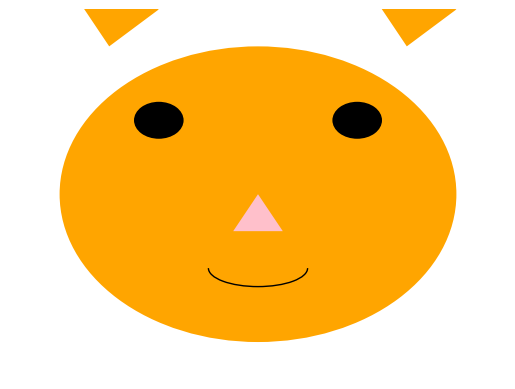

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Buat figure dan axes
fig, ax = plt.subplots()

# Gambar kepala (lingkaran)
head = patches.Circle((0.5, 0.5), 0.4, facecolor='orange')
ax.add_patch(head)

# Gambar mata (lingkaran)
eye1 = patches.Circle((0.3, 0.7), 0.05, facecolor='black')
eye2 = patches.Circle((0.7, 0.7), 0.05, facecolor='black')
ax.add_patch(eye1)
ax.add_patch(eye2)

# Gambar hidung (segitiga)
nose = patches.Polygon([(0.5, 0.5), (0.45, 0.4), (0.55, 0.4)], facecolor='pink')
ax.add_patch(nose)

# Gambar mulut (kurva)
mouth = patches.Arc((0.5, 0.3), 0.2, 0.1, theta1=180, theta2=360, facecolor='black')
ax.add_patch(mouth)

# Gambar telinga (segitiga)
ear1 = patches.Polygon([(0.2, 0.9), (0.1, 1.1), (0.3, 1.0)], facecolor='orange')
ear2 = patches.Polygon([(0.8, 0.9), (0.7, 1.1), (0.9, 1.0)], facecolor='orange')
ax.add_patch(ear1)
ax.add_patch(ear2)

# Atur batas axes
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Sembunyikan axes
ax.axis('off')

# Tampilkan gambar
plt.show()

<ipython-input-78-9277a2c2363b>:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  head = patches.Ellipse((0.5, 0.6), 0.8, 1.0, color='white', edgecolor='black', lw=2)
<ipython-input-78-9277a2c2363b>:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  left_eye = patches.Ellipse((0.35, 0.55), 0.13, 0.1, color='yellow', edgecolor='black', lw=2)
<ipython-input-78-9277a2c2363b>:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  right_eye = patches.Ellipse((0.65, 0.55), 0.13, 0.1, color='yellow', edgecolor='black', lw=2)
<ipython-input-78-9277a2c2363b>:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mouth_part = patches.Polygon([[0.4, 0.42], [0.6, 0.42], [0.55, 0.3], [0.45, 0.3]], closed=True, color='red', edgecolor='black', lw=2)
<ipython-input-78-9277a2c2363b>:39: UserWarning: Setting the 'c

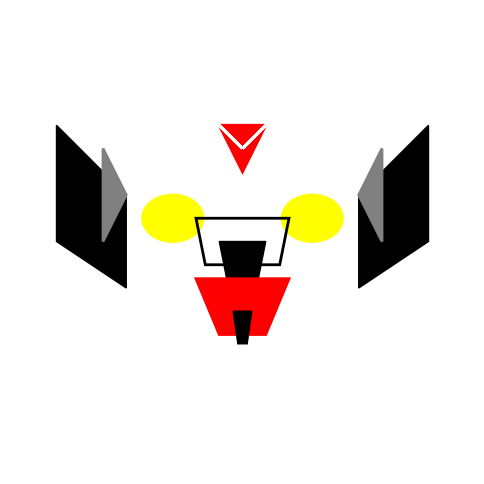

In [ ]:
# Refining the Gundam head shape and adding more details
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_aspect('equal')

# Background color
ax.set_facecolor('black')

# Drawing the main head (white faceplate)
head = patches.Ellipse((0.5, 0.6), 0.8, 1.0, color='white', edgecolor='black', lw=2)
ax.add_patch(head)

# Adding the side black plates for face shape
side_left = patches.Polygon([[0.1, 0.75], [0.25, 0.6], [0.25, 0.4], [0.1, 0.5]], closed=True, color='black')
side_right = patches.Polygon([[0.9, 0.75], [0.75, 0.6], [0.75, 0.4], [0.9, 0.5]], closed=True, color='black')
ax.add_patch(side_left)
ax.add_patch(side_right)

# Eyes (yellow with black outline)
left_eye = patches.Ellipse((0.35, 0.55), 0.13, 0.1, color='yellow', edgecolor='black', lw=2)
right_eye = patches.Ellipse((0.65, 0.55), 0.13, 0.1, color='yellow', edgecolor='black', lw=2)
ax.add_patch(left_eye)
ax.add_patch(right_eye)

# Face lines for additional details
face_line1 = patches.Polygon([[0.45, 0.5], [0.55, 0.5], [0.53, 0.4], [0.47, 0.4]], closed=True, color='black')
face_line2 = patches.Polygon([[0.4, 0.55], [0.6, 0.55], [0.58, 0.45], [0.42, 0.45]], closed=True, edgecolor='black', fill=False, lw=2)
ax.add_patch(face_line1)
ax.add_patch(face_line2)

# The red mouth area refined
mouth_part = patches.Polygon([[0.4, 0.42], [0.6, 0.42], [0.55, 0.3], [0.45, 0.3]], closed=True, color='red', edgecolor='black', lw=2)
ax.add_patch(mouth_part)

# Chin detail
chin = patches.Polygon([[0.48, 0.35], [0.52, 0.35], [0.51, 0.28], [0.49, 0.28]], closed=True, color='black')
ax.add_patch(chin)

# Forehead piece (red triangle on top)
forehead = patches.Polygon([[0.45, 0.75], [0.55, 0.75], [0.5, 0.65]], closed=True, color='red', edgecolor='black', lw=2)
ax.add_patch(forehead)

# Antennas (white V-shape) refined
left_antenna = patches.Polygon([[0.3, 0.9], [0.5, 0.7], [0.35, 0.85]], closed=True, color='white', edgecolor='black', lw=2)
right_antenna = patches.Polygon([[0.7, 0.9], [0.5, 0.7], [0.65, 0.85]], closed=True, color='white', edgecolor='black', lw=2)
ax.add_patch(left_antenna)
ax.add_patch(right_antenna)

# Adding more details to the side
left_side_detail = patches.Polygon([[0.2, 0.7], [0.25, 0.6], [0.2, 0.5]], closed=True, color='grey', edgecolor='black', lw=2)
right_side_detail = patches.Polygon([[0.8, 0.7], [0.75, 0.6], [0.8, 0.5]], closed=True, color='grey', edgecolor='black', lw=2)
ax.add_patch(left_side_detail)
ax.add_patch(right_side_detail)

# Adding text label for RX-78-2
plt.text(0.5, 0.1, 'RX-78-2\nGUNDAM', color='white', fontsize=14, fontweight='bold', ha='center')

# Remove axis
ax.axis('off')

# Display the image
plt.show()
